# NYC Open Data - Schools Spatial Join
Case study of joining data to street segment using School data from NYC Open Data. Three parts:

This is done with the entire city to show how to do it in a more efficient way.

1. Data Ingestion
2. Spatial Join of Schools to Road Segments
3. Aggregating data by osmid 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import rtree

from shapely.geometry import Point, box
from shapely import wkt

from fiona.crs import from_epsg
%matplotlib inline

### I. Import shapefiles and convert to appropriate coordinate system

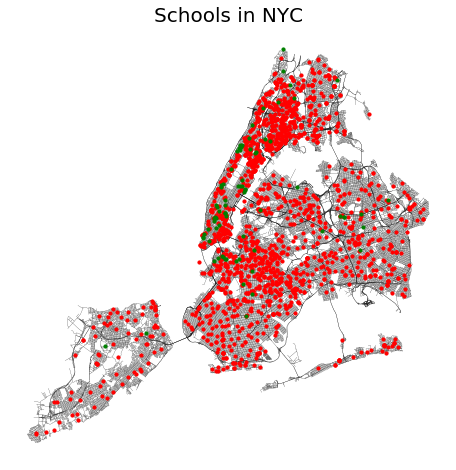

In [2]:
# Ingest data and convert to long island state plane so we can use ft as units
segs = gpd.read_file('../road_network_data/osm/osm_w_collisions/edges/edges.shp').to_crs({'init': 'epsg:2263'})
nodes = gpd.read_file('../road_network_data/osm/osm_w_collisions/nodes/nodes.shp').to_crs({'init': 'epsg:2263'})

# Get schools from CSV
schools = pd.read_csv('2017_-_2018_School_Locations.csv')

#Transform to GeoDataFrame
schools['geometry'] = schools.apply(lambda x: Point(x['X_COORDINATE'], x['Y_COORDINATE']), axis=1)
schools = gpd.GeoDataFrame(schools)
schools.crs = from_epsg(2263)

#Remove schools without location (only one)
schools = schools[~schools.X_COORDINATE.isna()]

#Get Colleges and Universities
college_univ = pd.read_csv('COLLEGE_UNIVERSITY.csv')
college_univ['geometry'] = college_univ.the_geom.apply(lambda x: wkt.loads(x))
college_univ = gpd.GeoDataFrame(college_univ, crs=from_epsg(4326)).to_crs(epsg=2263)


fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Schools in NYC', fontsize=20)
segs.plot(color='black', ax= ax, lw=0.2, zorder=-1)
#nodes.plot(markersize=0.1, ax= ax)
schools.plot(color='red', markersize=10, ax=ax)
college_univ.plot(color='green', markersize=10, ax=ax)
ax.axis('off')

plt.show()

In [3]:
segs.columns

Index(['access', 'bridge', 'from', 'highway', 'junction', 'key', 'lanes',
       'length', 'maxspeed', 'name', 'oneway', 'osmid', 'ref', 'service', 'to',
       'tunnel', 'width', 'id', 'LBlockFace', 'RBlockFace', 'FIRST_Traf',
       'MAX_Number', 'MAX_Numb_1', 'MAX_Numb_2', 'MAX_POSTED', 'FIRST_Bike',
       'FIRST_Stre', 'MAX_Street', 'MIN_Street', 'geometry'],
      dtype='object')

### II. "Spatially join" road data to schools

Not sure if join by closest distance can be done with GeoPandas, so I'm calculating the closest road segment to each Google Place and assigning it the OSM id.

#### First create an Rtree index to make the search faster

In [4]:
index = rtree.Rtree()
for idx, geometry in enumerate(segs.geometry):
    index.insert(idx, geometry.bounds)

def closest_segment_id_rtree(point, index, segments):
    match = list(index.nearest((point.x, point.y, point.x, point.y)))
    if len(match):
        return segments.loc[segments.loc[match, 'geometry'].distance(point).idxmin(),'id']
    else:
        return None
    
def closest_segment_id(point, segments):
    return segments.loc[segments.geometry.distance(point).idxmin(),'id']

In [5]:
len(segs), len(schools)

(91666, 1822)

In [6]:
%time schools['segid'] = schools.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 3.51 s, sys: 50 ms, total: 3.56 s
Wall time: 4.29 s


In [7]:
schools.segid.isna().sum()

0

In [8]:
%time college_univ['segid'] = college_univ.geometry.apply(lambda x: closest_segment_id_rtree(x, index, segs))

CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 296 ms


In [9]:
college_univ.segid.isna().sum()

0

All schools and colleges are matched to a segment

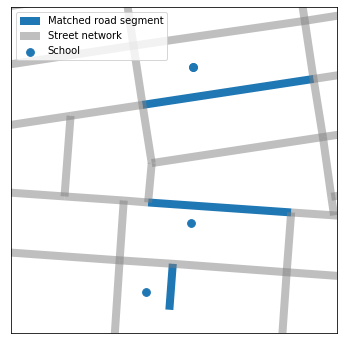

In [41]:
# visualize joined data (zoomed in)
fig, ax = plt.subplots(figsize=(6,6))

matched_segids = list(schools.segid.unique()) + list(college_univ.segid.unique())

ax.set_title('', fontsize=20)
segs[segs.id.isin(matched_segids)].plot(color='tab:blue', ax= ax, lw=8, zorder=-1, label='Matched road segment')
segs[~segs.id.isin(matched_segids)].plot(color='grey', ax= ax, lw=8, zorder=-1, alpha=0.5, label='Street network')
#nodes.plot(markersize=0.3, ax= ax)
schools.plot(color='tab:blue', markersize=60, ax=ax, label='School')
college_univ.plot(color='tab:blue', markersize=60, ax=ax)


ax.set_xlim(998500, 1000000)
ax.set_ylim(186500, 188000)
#ax.axis('off')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.legend(loc=2)

plt.show()

### III. (a) Encode any school type as binary per segment

In [19]:
all_school_types = pd.concat([college_univ[['segid']], schools[['segid']]]).drop_duplicates()
all_school_types['school'] = 1
all_school_types = pd.merge(all_school_types, segs, left_on='segid', right_on='id', how='right')[['segid', 'school']].fillna(0).astype(int)
all_school_types.head()

,segid,school
0,74501,1
1,34605,1
2,65611,1
3,43441,1
4,34458,1


In [20]:
all_school_types.shape

(91666, 2)

In [21]:
all_school_types.school.value_counts()

0    90371
1     1295
Name: school, dtype: int64

In [22]:
all_school_types.to_csv('joined_schools_new.csv',index=False)

### III. (b) Aggregate schools to SoP variables per segment


#### 1. School variables (kinder, primschl, scndschl, highschl, schother)

In [29]:
# available columns
schools.columns

Index(['FISCAL_YEAR', 'ATS SYSTEM CODE', 'LOCATION_CODE', 'LOCATION_NAME',
       'BEDS NUMBER', 'MANAGED_BY_NAME', 'LOCATION_TYPE_DESCRIPTION',
       'LOCATION_CATEGORY_DESCRIPTION', 'GRADES_TEXT', 'GRADES_FINAL_TEXT',
       'OPEN_DATE', 'STATUS_DESCRIPTIONS', 'PRIMARY_BUILDING_CODE',
       'PRIMARY_ADDRESS_LINE_1', 'STATE_CODE', 'X_COORDINATE', 'Y_COORDINATE',
       'COMMUNITY_DISTRICT', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BOROUGH_BLOCK_LOT', 'NTA', 'NTA_NAME', 'PRINCIPAL_NAME',
       'PRINCIPAL_TITLE', 'PRINCIPAL_PHONE_NUMBER', 'FAX_NUMBER',
       'GEOGRAPHICAL_DISTRICT_CODE', 'ADMIN_DISTRICT_LOCATION_CODE',
       'ADMINISTRATIVE_DISTRICT_NAME', 'COMMUNITY_SCHOOL_SUP_NAME',
       'FIELD_SUPPORT_CENTER_NAME', 'FIELD_SUPPORT_CENTER_LEADER_NAME',
       'SCHOOL_SUPPORT_TEAM_NAME', 'SCHOOL_SUPPORT_TEAM_LEADER_NAME',
       'HIGHSCHOOL_NETWORK_LOCATION_CODE', 'HIGHSCHOOL_NETWORK_NAME',
       'HIGHSCHOOL_NETWORK_SUPERINTENDENT', 'Location 1', 'geometry', 'segid'],
      d

In [30]:
#School categories
schools.LOCATION_CATEGORY_DESCRIPTION.value_counts()

Elementary                         716
High school                        427
Junior High-Intermediate-Middle    283
K-8                                210
Secondary School                   103
K-12 all grades                     64
Early Childhood                     17
Ungraded                             2
Name: LOCATION_CATEGORY_DESCRIPTION, dtype: int64

In [31]:
#School categories to SoP variable - NOT SURE ABOUT SOME

#kinder - Kindergarten
#primschl - Primary School
#scndschl - Secondary School
#highschl - High School
#schother - School, Other

school_to_sop = {
    'Elementary' : 'primschl',
    'High school' : 'highschl',
    'Junior High-Intermediate-Middle' : 'scndschl',
    'K-8' : 'primschl',
    'Secondary School' : 'scndschl',
    'K-12 all grades' : 'schother',
    'Early Childhood' : 'kinder',
    'Ungraded' : 'schother'
}

In [32]:
#This is helpful when a single columns translates to multiple SoP variables
def get_sop_vars(df, column, transform_dict):
    sop_vars = list(set(df[column].apply(lambda x: transform_dict[x])))
    return pd.DataFrame(columns=sop_vars, data=[[1]*len(sop_vars)])

In [33]:
#schools.groupby('segid').agg(get_sop_vars)
schools.groupby('segid').get_group(1035)

,FISCAL_YEAR,ATS SYSTEM CODE,LOCATION_CODE,LOCATION_NAME,BEDS NUMBER,MANAGED_BY_NAME,LOCATION_TYPE_DESCRIPTION,LOCATION_CATEGORY_DESCRIPTION,GRADES_TEXT,GRADES_FINAL_TEXT,...,FIELD_SUPPORT_CENTER_NAME,FIELD_SUPPORT_CENTER_LEADER_NAME,SCHOOL_SUPPORT_TEAM_NAME,SCHOOL_SUPPORT_TEAM_LEADER_NAME,HIGHSCHOOL_NETWORK_LOCATION_CODE,HIGHSCHOOL_NETWORK_NAME,HIGHSCHOOL_NETWORK_SUPERINTENDENT,Location 1,geometry,segid
501,2018,10X243,X243,West Bronx Academy for the Future,321000011243,DOE,General Academic,Secondary School,"06,07,08,09,10,11,12,SE","06,07,08,09,10,11,12",...,Affinity Group,"ANORMALIZA, ALEXANDRA",School Support Team 2- Affinity Group,NaN,HS08,H.S. Network 08 Superintendent Office,"MENDEZ, JUAN","500 EAST FORDHAM ROAD\nBRONX, NY 10458\n(40.85...",POINT (1015058 252424),1035
526,2018,10X374,X374,Knowledge and Power Preparatory Academy Intern...,321000011374,DOE,General Academic,High school,"09,10,11,12,SE","09,10,11,12",...,Affinity Group,"ANORMALIZA, ALEXANDRA",School Support Team 2- Affinity Group,NaN,HS08,H.S. Network 08 Superintendent Office,"MENDEZ, JUAN","500 EAST FORDHAM ROAD\nBRONX, NY 10458\n(40.85...",POINT (1015058 252424),1035
534,2018,10X434,X434,Belmont Preparatory High School,321000011434,DOE,General Academic,High school,"09,10,11,12,SE","09,10,11,12",...,Affinity Group,"ANORMALIZA, ALEXANDRA",School Support Team 2- Affinity Group,NaN,HS08,H.S. Network 08 Superintendent Office,"MENDEZ, JUAN","500 EAST FORDHAM ROAD\nBRONX, NY 10458\n(40.85...",POINT (1015058 252424),1035
535,2018,10X437,X437,Fordham High School for the Arts,321000011437,DOE,General Academic,High school,"09,10,11,12,SE","09,10,11,12",...,Field Support Center - Bronx,"RUIZ, JOSE",School Support Team 1- Bronx,NaN,HS02,H.S. Network 02 Superintendent Office,"STAPLE, CARRON","500 EAST FORDHAM ROAD\nBRONX, NY 10458\n(40.85...",POINT (1015058 252424),1035
536,2018,10X438,X438,Fordham Leadership Academy,321000011438,DOE,General Academic,High school,"09,10,11,12,SE","09,10,11,12",...,Field Support Center - Bronx,"RUIZ, JOSE",School Support Team 2- Bronx,NaN,HS09,H.S. Network 09 Superintendent Office,"ALCOFF, MICHAEL","500 EAST FORDHAM ROAD\nBRONX, NY 10458\n(40.85...",POINT (1015058 252424),1035
537,2018,10X439,X439,Bronx High School for Law and Community Service,321000011439,DOE,General Academic,High school,"09,10,11,12,SE","09,10,11,12",...,Affinity Group,"ANORMALIZA, ALEXANDRA",School Support Team 2- Affinity Group,NaN,HS08,H.S. Network 08 Superintendent Office,"MENDEZ, JUAN","500 EAST FORDHAM ROAD\nBRONX, NY 10458\n(40.85...",POINT (1015058 252424),1035


In [34]:
get_sop_vars(schools.groupby('segid').get_group(1035), 'LOCATION_CATEGORY_DESCRIPTION',school_to_sop)

,highschl,scndschl
0,1,1


In [35]:
final_df = schools.groupby('segid').apply(get_sop_vars, 'LOCATION_CATEGORY_DESCRIPTION',school_to_sop).reset_index(level=1, drop=True).fillna(0).astype(int)
final_df.head()

,highschl,scndschl,primschl,kinder,schother
segid,,,,,
42,1,0,0,0,0
52,0,1,0,0,0
66,1,0,0,0,0
95,1,0,0,0,0
123,0,0,1,0,0


#### 2. College/University (college)

In [36]:
college_univ.columns

Index(['the_geom', 'NAME', 'HOUSENUM', 'STREETNAME', 'CITY', 'ZIP', 'URL',
       'BIN', 'BBL', 'geometry', 'segid'],
      dtype='object')

In [44]:
college_var = pd.DataFrame(index=college_univ.segid.unique(), columns=['college']).fillna(1)
college_var.index.name = 'segid'
college_var.head()

,college
segid,
74501,1
34605,1
65611,1
43441,1
34458,1


In [47]:
final_df = pd.merge(final_df, college_var, right_index=True, left_index=True, how='outer').fillna(0).astype(int)
final_df.head()

,highschl,scndschl,primschl,kinder,schother,college
segid,,,,,,
42,1,0,0,0,0,0
52,0,1,0,0,0,0
66,1,0,0,0,0,0
95,1,0,0,0,0,0
123,0,0,1,0,0,0


In [48]:
final_df.to_csv('joined_schools.csv')

I think it's better to save the above and then merge everything together into a shapefile when we have all variables. I'll do the merge only to plot.

In [49]:
variables = ['highschl', 'scndschl', 'primschl', 'kinder', 'schother', 'college']

segs_joined = pd.merge(segs, final_df, left_on='id', right_index=True, how='left').fillna(0)
segs_joined[variables] = segs_joined[variables].astype(int)

#### Plot result

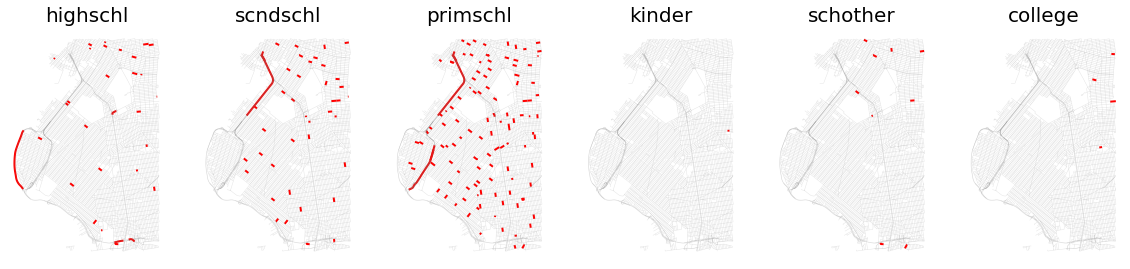

In [50]:
n = len(variables)

fig, axes = plt.subplots(ncols=n, figsize=(20,8))

#Set a boundary to plot part of the city
minx, miny, maxx, maxy = (970000, 150000, 1000000, 190000)
sample_bounds = box(minx, miny, maxx, maxy)
segs_joined_sample = segs_joined[segs_joined.within(sample_bounds)]

for i, var in enumerate(variables):
    ax = axes[i]
    segs_joined_sample[segs_joined_sample[var] == 1].plot(color='red', ax=ax, lw=2, zorder=-1, label=var)
    segs_joined_sample[segs_joined_sample[var] == 0].plot(color='grey', ax=ax, lw=0.5, zorder=-1, label=var, alpha=0.2)
    ax.set_title(var, fontsize=20)
    ax.axis('off')

plt.show()